# Continuous gene expression gradients in the cerebellum

In [1]:
import sys
import os
from collections import defaultdict
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from glmpca import glmpca
from itertools import combinations
import torch

import sys
from importlib import reload

import gaston
from gaston import neural_net,cluster_plotting, dp_related, segmented_fit, model_selection
from gaston import binning_and_plotting, isodepth_scaling, parse_adata
from gaston import spatial_gene_classification, plot_cell_types, filter_genes, process_NN_output
from gaston import run_slurm_scripts, run_commandline_scripts

import seaborn as sns
import math

## Step 1: Pre-processing

GASTON requires: 
- N x G counts matrix
- N x 2 spatial coordinate matrix,
- list of names for each gene

where N=number of spatial locations and G=number of genes.

There are two options for pre-processing: (1) using GLM-PCA or (2) using top PCs of Pearson residuals. We recommend option 1, which is slower but yields much better results.

## Option 1: GLMPCA (recommended)

We run GLMPCA to compute the top PCs.

In [2]:
!mkdir -p cerebellum_tutorial_outputs

In [2]:
counts_mat=np.load('cerebellum_data/cerebellum_counts_mat.npy') # N x G UMI count array
coords_mat=np.load('cerebellum_data/cerebellum_coords_mat.npy') # N x 2 spatial coordinate matrix
gene_labels=np.load('cerebellum_data/cerebellum_gene_labels.npy', allow_pickle=True) # list of names for G genes

Optional: remove spots with low number of UMIs

In [3]:
# OPTIONAL: filter out cells with UMI below spot_umi_threshold
spot_umi_threshold=0

spots_to_keep=np.sum(counts_mat, axis=1)>=spot_umi_threshold
print(f'number of removed spots: {counts_mat.shape[0]-spots_to_keep.sum()}')
counts_mat=counts_mat[spots_to_keep,:]
coords_mat=coords_mat[spots_to_keep,:]

number of removed spots: 0


GLM-PCA typically takes 10-30 minutes to run. To improve the run-time of GLM-PCA, there are three parameters that can be adjusted.
1. Number of iterations `num_iters` - smaller value reduces runtime
2. Convergence threshold `eps` - larger value reduces runtime
3. Number of genes `num_genes` - smaller value reduces runtime

In [4]:
# GLM-PCA parameters
num_dims=8 # 2 * number of clusters
penalty=10 # may need to increase if this is too small

# CHANGE THESE PARAMETERS TO REDUCE RUNTIME
num_iters=30
eps=1e-4
num_genes=30000

counts_mat_glmpca=counts_mat[:,np.argsort(np.sum(counts_mat, axis=0))[-num_genes:]]
glmpca_res=glmpca.glmpca(counts_mat_glmpca.T, num_dims, fam="poi", penalty=penalty, verbose=True,
                        ctl = {"maxIter":num_iters, "eps":eps, "optimizeTheta":True})
A = glmpca_res['factors'] # should be of size N x num_dims, where each column is a PC

np.save('cerebellum_data/glmpca.npy', A)

Iteration: 0 | deviance=2.2707E+7
Iteration: 1 | deviance=2.2707E+7
Iteration: 2 | deviance=2.2549E+7
Iteration: 3 | deviance=3.4943E+7
Iteration: 4 | deviance=2.1138E+7
Iteration: 5 | deviance=2.1024E+7
Iteration: 6 | deviance=2.0970E+7
Iteration: 7 | deviance=2.0939E+7
Iteration: 8 | deviance=2.0919E+7
Iteration: 9 | deviance=2.0904E+7
Iteration: 10 | deviance=2.0893E+7
Iteration: 11 | deviance=2.0884E+7
Iteration: 12 | deviance=2.0877E+7
Iteration: 13 | deviance=2.0871E+7
Iteration: 14 | deviance=2.0865E+7
Iteration: 15 | deviance=2.0861E+7
Iteration: 16 | deviance=2.0857E+7
Iteration: 17 | deviance=2.0854E+7
Iteration: 18 | deviance=2.0851E+7
Iteration: 19 | deviance=2.0848E+7
Iteration: 20 | deviance=2.0846E+7
Iteration: 21 | deviance=2.0843E+7


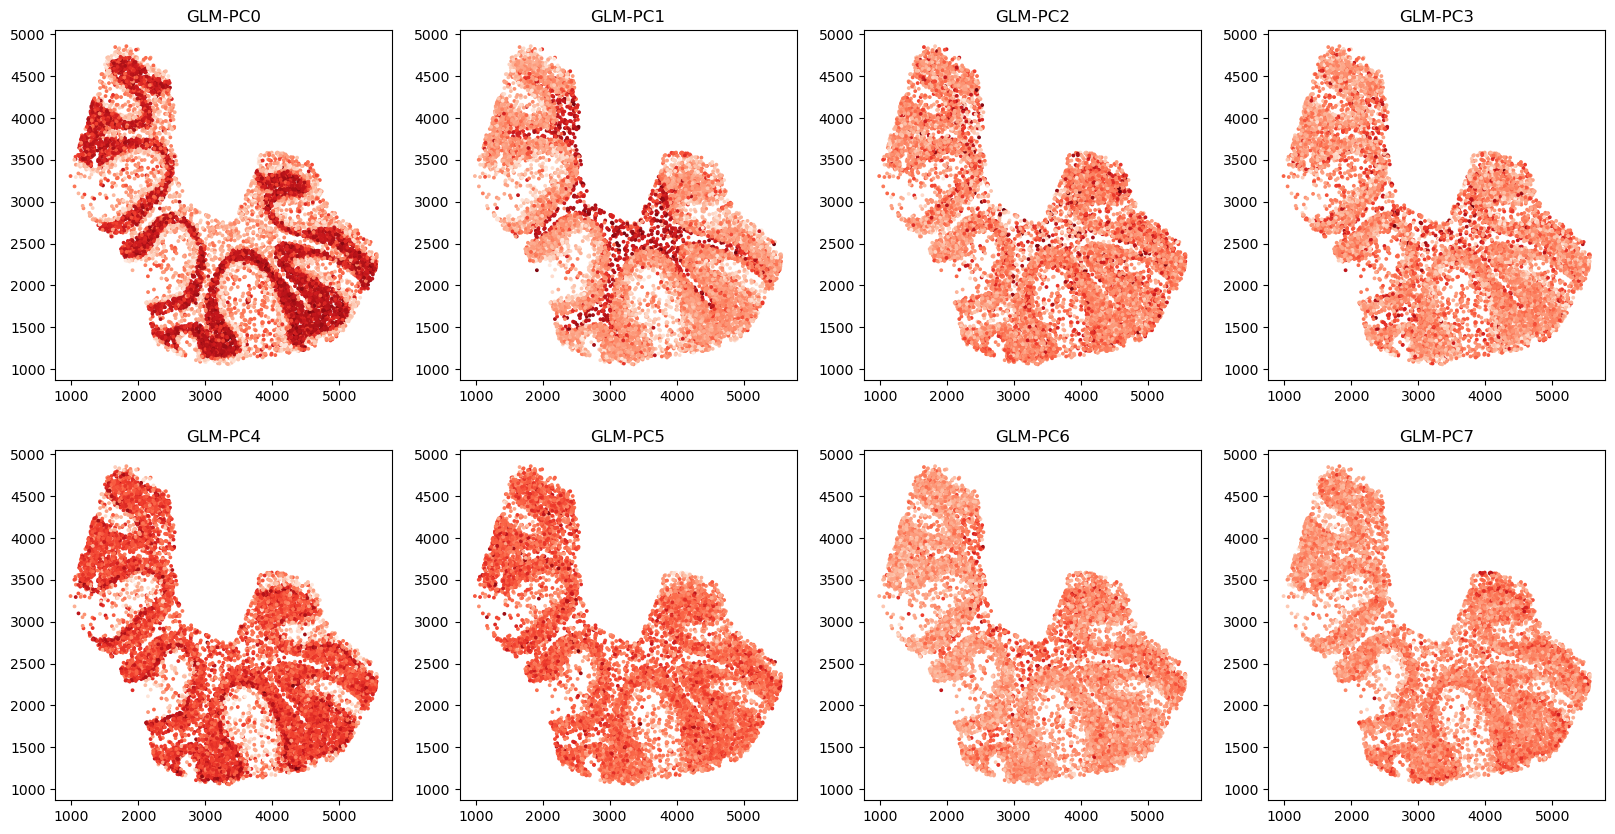

In [5]:
# visualize top GLM-PCs
R=2
C=4
fig,axs=plt.subplots(R,C,figsize=(20,10))
for r in range(R):
    for c in range(C):
        i=r*C+c
        axs[r,c].scatter(coords_mat[:,0], coords_mat[:,1], c=A[:,i],cmap='Reds',s=3)
        axs[r,c].set_title(f'GLM-PC{i}')

## Option 2: use top PCs of analytic Pearson residuals

Here we compute PCA on analytic Pearson residuals following the Scanpy tutorial https://scanpy-tutorials.readthedocs.io/en/latest/tutorial_pearson_residuals.html tutorial . This is faster than GLM-PCA, but the PCs are of lower quality, so it is not recommended


In [22]:
num_dims=8 # 2 * number of clusters
clip=0.01 # have to clip values to be very small!

A = parse_adata.get_top_pearson_residuals(num_dims,counts_mat,coords_mat,gene_labels,clip=clip)
np.save('cerebellum_data/analytic_pearson.npy', A)

/n/fs/ragr-data/users/uchitra/miniconda3/envs/gaston-package/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/n/fs/ragr-data/users/uchitra/miniconda3/envs/gaston-package/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/n/fs/ragr-data/users/uchitra/miniconda3/envs/gaston-package/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


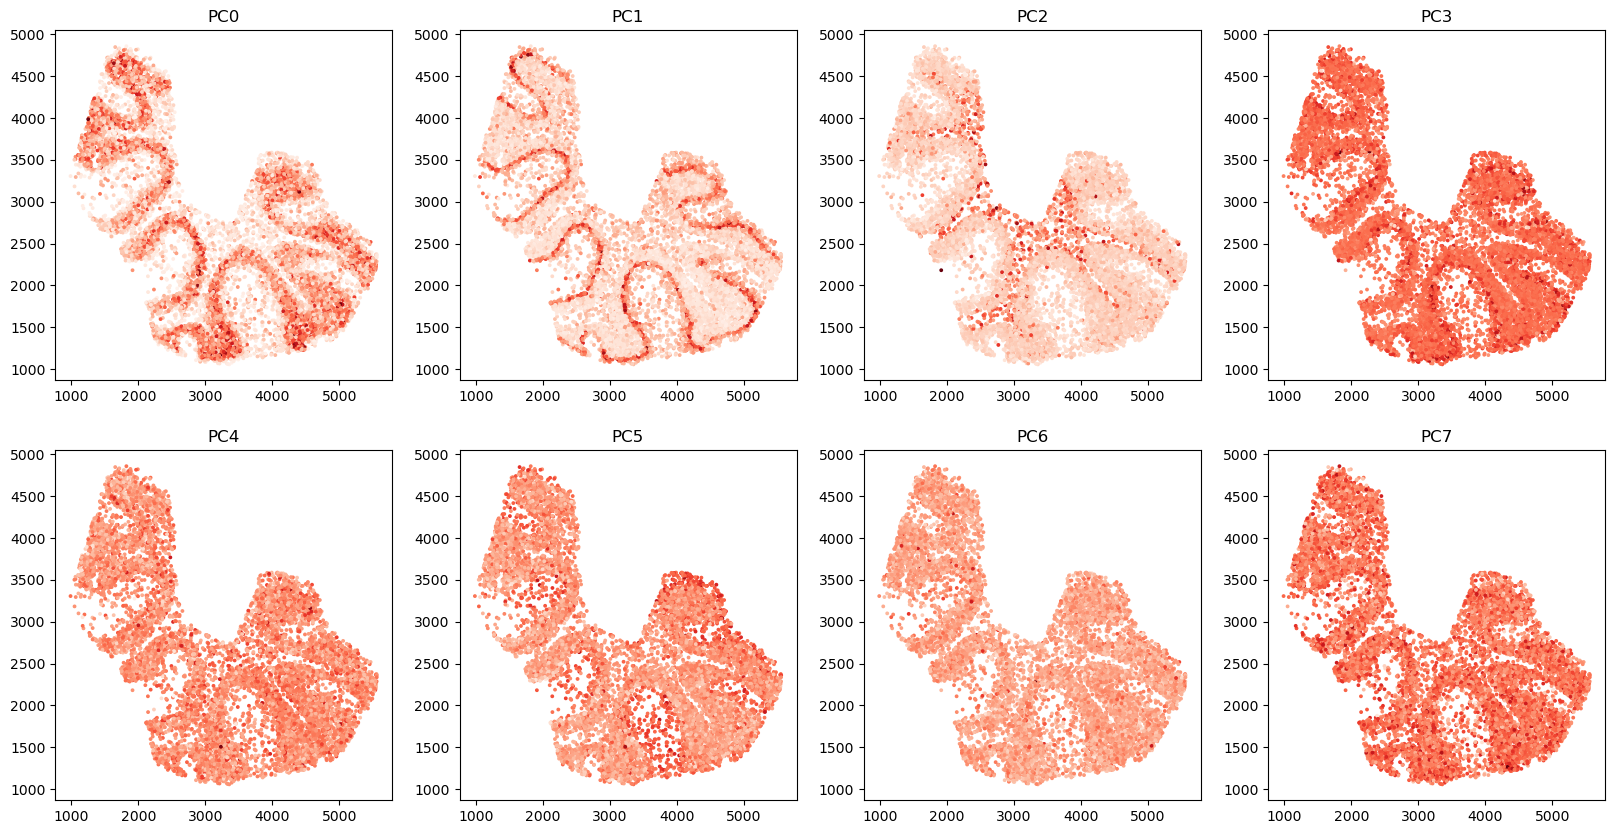

In [23]:
# visualize top GLM-PCs
R=2
C=4
fig,axs=plt.subplots(R,C,figsize=(20,10))
for r in range(R):
    for c in range(C):
        i=r*C+c
        axs[r,c].scatter(coords_mat[:,0], coords_mat[:,1], c=A[:,i],cmap='Reds',s=3)
        axs[r,c].set_title(f'PC{i}')

## Step 2: Train GASTON neural network

We include how to train the neural network with two options: (1) a command line script and (2) in a notebook. We typically train the neural network 30 different times, each with a different seed, and we use the NN with lowest loss. 

### Option 1: command line (recommended, can parallelize)

First, we need to define some parameters.

In [17]:
# Coords, GLM-PCAs created above
# path_to_coords='cerebellum_data/cerebellum_coords_mat.npy'
# path_to_glmpca='tutorial_outputs/glmpca.npy'

# To approximately recreate paper figures, use same GLM-PCs from paper 
path_to_coords='cerebellum_data/cerebellum_coords_mat.npy'
path_to_glmpca='cerebellum_data/F_glmpca_penalty_10_rep1.npy' # for the GLM-PCs from paper
# path_to_glmpca='cerebellum_data/glmpca.npy' # for the GLM-PCs from above
# path_to_glmpca='cerebellum_data/analytic_pearson.npy' # for the PCs of analytic Pearson residuals from above

##################################

# GASTON NN parameters
isodepth_arch=[20,20] # architecture (two hidden layers of size 20) for isodepth neural network d(x,y)
expression_arch=[20,20] # architecture (two hidden layers of size 20) for 1-D expression function
epochs = 10000 # number of epochs to train NN
checkpoint = 500 # save model after number of epochs = multiple of checkpoint
optimizer = "adam"
num_restarts=30 # number of initializations
pos_encoding=True # whether or not to use positional encoding for isodepth network (NOT used in paper)

output_dir='cerebellum_tutorial_outputs2' # folder to save model runs

# REPLACE with your own conda environment name and path
conda_environment='gaston-package'
path_to_conda='/home/uthsav/miniforge3/bin/activate'
partition='raphael' # if you have a separate partition on the cluster

time='0-01:00:00' # max time for slurm job, currently 1 hour -- may need to increase

#### Option 1a: If you have Slurm

This code creates different 30 Slurm jobs, one for each initialization.

In [9]:
run_slurm_scripts.train_NN_parallel(path_to_coords, path_to_glmpca, isodepth_arch, expression_arch, 
                      output_dir, conda_environment, path_to_conda,
                      epochs=epochs, checkpoint=checkpoint, 
                      num_seeds=num_restarts, partition=partition, pos_encoding=pos_encoding, time=time)

jobId: 19671859
jobId: 19671860
jobId: 19671861
jobId: 19671862
jobId: 19671863
jobId: 19671864
jobId: 19671865
jobId: 19671866
jobId: 19671867
jobId: 19671868
jobId: 19671869
jobId: 19671870
jobId: 19671871
jobId: 19671872
jobId: 19671873
jobId: 19671874
jobId: 19671875
jobId: 19671876
jobId: 19671877
jobId: 19671878
jobId: 19671879
jobId: 19671880
jobId: 19671881
jobId: 19671882
jobId: 19671883
jobId: 19671884
jobId: 19671885
jobId: 19671886
jobId: 19671887
jobId: 19671888


Wait for models to finish training. You can check on their status by running `squeue -u uchitra`  -- replacing `uchitra` with your username

#### Option 1b: If you do not have Slurm.
Then we directly train using command line.

In [23]:
reload(run_commandline_scripts)
parallel_processes=30

run_commandline_scripts.train_NN_parallel(path_to_coords, path_to_glmpca, isodepth_arch, expression_arch, 
                      output_dir, conda_environment, path_to_conda,
                      epochs=epochs, checkpoint=checkpoint, 
                      num_seeds=30, pos_encoding=pos_encoding, 
                      parallel_processes=parallel_processes)

Starting training for all seeds in parallel...
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
device: cpu
Bash script executed: cerebellum_tutorial_outputs2/run_all_seeds.sh



For both options, if one wants to train the NN for a single initialization, then run the following command:

`gaston -i /path/to/coords.npy -o /path/to/glmpca.npy -d /path/to/output_dir -e 10000 -c 500 -p 20 20 -x 20 20 -s SEED --positional_encoding`

for a given `SEED` value (integer)

### Option 2: train in notebook (not recommended, slower)

We first load GLM-PCs and coordinates and z-score normalize.

In [289]:
# Load N x G matrix A of GLM-PCs, and N x 2 matrix S
# A=np.load('tutorial_outputs/glmpca.npy') # GLM-PCA results from above
A=np.load('data/cerebellum/F_glmpca_penalty_10_rep1.npy') # GLM-PCA results used in manuscript
S=coords_mat

# z-score normalize S and A
S_torch, A_torch = neural_net.load_rescale_input_data(S,A)

Next we train the neural network, once for each random initialization.

In [260]:
######################################
# NEURAL NET PARAMETERS (USER CAN CHANGE)
# architectures are encoded as list, eg [20,20] means two hidden layers of size 20 hidden neurons
isodepth_arch=[20,20] # architecture for isodepth neural network d(x,y) : R^2 -> R 
expression_fn_arch=[20,20] # architecture for 1-D expression function h(w) : R -> R^G

num_epochs = 10000 # number of epochs to train NN (NOTE: it is sometimes beneficial to train longer)
checkpoint = 500 # save model after number of epochs = multiple of checkpoint
out_dir='tutorial_outputs' # folder to save model runs
optimizer = "adam"
num_restarts=30

######################################

seed_list=range(num_restarts)
for seed in seed_list:
    print(f'training neural network for seed {seed}')
    out_dir_seed=f"{out_dir}/rep{seed}"
    os.makedirs(out_dir_seed, exist_ok=True)
    mod, loss_list = neural_net.train(S_torch, A_torch,
                          S_hidden_list=isodepth_arch, A_hidden_list=expression_fn_arch, 
                          epochs=num_epochs, checkpoint=checkpoint, 
                          save_dir=out_dir_seed, optim=optimizer, seed=seed, save_final=True)

training neural network for seed 19


## Step 3: Process neural network output

Note that if you use your own trained model, figures may not match the manuscript. This is because (1) we recently added positional encoding for faster training and (2) even if one disables positional encoding, the models may not exactly match due to PyTorch non-determinism in seeding (see https://github.com/pytorch/pytorch/issues/7068 for details). 

Thus, we also include the model used in the paper for reproducibility.

### Visualize isodepth (topographic map) and spatial domains

Load best model

In [2]:
# MODEL TRAINED ABOVE
gaston_model, A, S= process_NN_output.process_files('cerebellum_tutorial_outputs2')

# TO MATCH PAPER FIGURES
# gaston_model, A, S= process_NN_output.process_files('cerebellum_data/reproduce_cerebellum') 

# may need to re-load counts_mat, coords_mat, gene_labels from previous step
counts_mat=np.load('cerebellum_data/cerebellum_counts_mat.npy') # N x G UMI count array
coords_mat=np.load('cerebellum_data/cerebellum_coords_mat.npy') # N x 2 spatial coordinate matrix
gene_labels=np.load('cerebellum_data/cerebellum_gene_labels.npy', allow_pickle=True) # list of names for G genes


best model: cerebellum_tutorial_outputs2/seed25


**Model selection** for choosing number of layers

Kneedle number of domains: 4


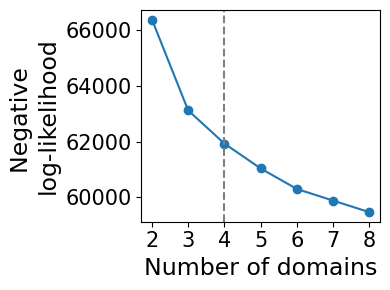

In [3]:
reload(model_selection)
model_selection.plot_ll_curve(gaston_model, A, S, max_domain_num=8, start_from=2)

Compute isodepth and gaston labels from model

In [4]:
reload(dp_related)
# CHANGE FOR YOUR APPLICATION: use number of domains from above!
num_layers=4 

# identify labels
gaston_isodepth, gaston_labels=dp_related.get_isodepth_labels(gaston_model,A,S,num_layers)

# DATASET-SPECIFIC: so domains are ordered oligodendrocyte to molecular, with increasing isodepth
gaston_isodepth=np.max(gaston_isodepth) - gaston_isodepth
gaston_labels=(num_layers-1)-gaston_labels

OPTIONAL: Scale isodepth to approximately reflect physical distances.

NOTE: `q_vals=[0.2, 0.05, 0.15, 0.3]` was manually chosen for the cerebellum. 
You may omit the argument for other datasets (automatically uses 0.05)

In [5]:
scale_factor=64/100 # since 64 pixels = 100 microns in slide-seq image

# WITH VISUALIZATION
# gaston_isodepth=isodepth_scaling.adjust_isodepth(gaston_isodepth, gaston_labels, coords_mat, 
#                                  q_vals=[0.2, 0.05, 0.15, 0.3], visualize=True, figsize=(12,12),num_rows=2)

# WITHOUT
gaston_isodepth=isodepth_scaling.adjust_isodepth(gaston_isodepth, gaston_labels, coords_mat, 
                                 q_vals=[0.2, 0.05, 0.15, 0.3], scale_factor=scale_factor)

Topographic map of isodepth + contours

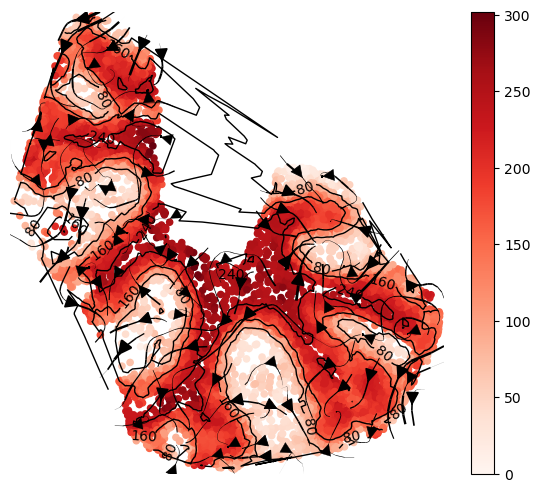

In [10]:
reload(cluster_plotting)
show_streamlines=True
cluster_plotting.plot_isodepth(gaston_isodepth, S, gaston_model, figsize=(7,6), streamlines=show_streamlines, cmap='Reds',
                              neg_gradient=True) # since we did isodepth -> -1*isodepth above, we also need to do gradient -> -1*gradient

Spatial domains

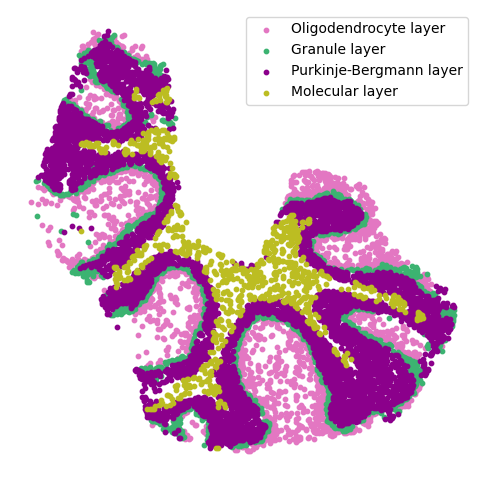

In [11]:
labels=['Oligodendrocyte layer', 'Granule layer', 'Purkinje-Bergmann layer', 'Molecular layer']

# WITHOUT CUSTOM COLORS
# cluster_plotting.plot_clusters(gaston_labels, S, figsize=(6,6), colors=None, 
#                                color_palette=plt.cm.Dark2, s=10,labels=labels,lgd=True)

# TO PLOT WITH CUSTOM COLORS:
domain_colors=['C6', 'mediumseagreen', 'darkmagenta', 'C8']
cluster_plotting.plot_clusters(gaston_labels, S, figsize=(6,6), 
                               colors=domain_colors, s=10,labels=labels,lgd=True)

### Plot cell type vs isodepth (if cell type info available)

Load cell type label per spot (from RCTD). We store as N x C dataframe M where M[i,c]=1 if spot i is cell type c, and 0 if not

In [10]:
cell_type_df=pd.read_csv('cerebellum_data/cell_type_df.csv', index_col=0)
cell_type_df

,Astrocytes,Bergmann,Candelabrum,Choroid,Endothelial,Ependymal,Fibroblast,Globular,Golgi,Granule,Lugaro,MLI1,MLI2,Macrophages,Microglia,Oligodendrocytes,Polydendrocytes,Purkinje,UBCs
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9981,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9983,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0


(6, 50) ['Purkinje', 'MLI1', 'Oligodendrocytes', 'MLI2', 'Granule', 'Bergmann']


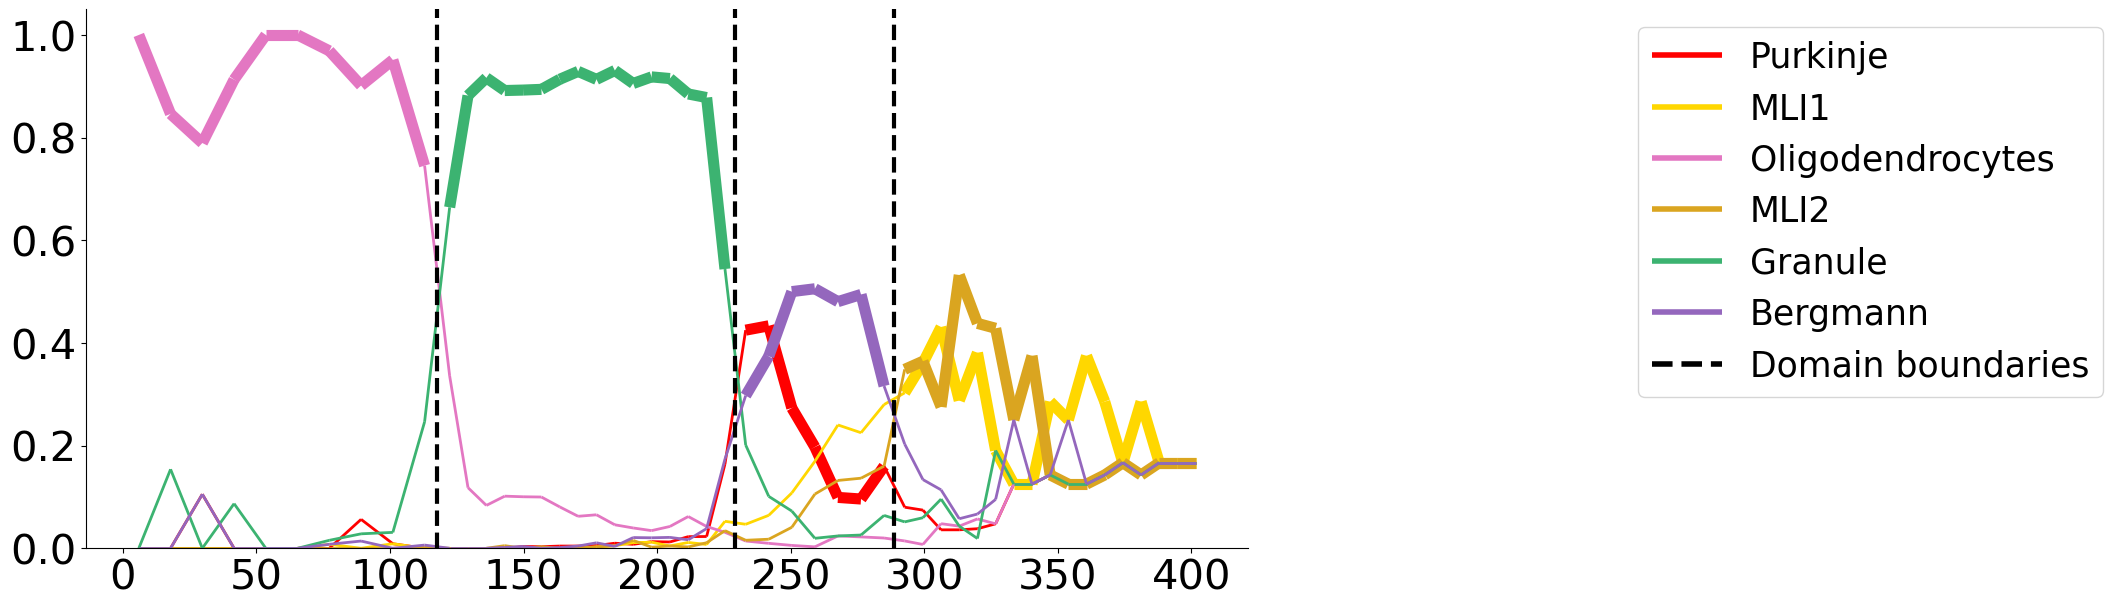

In [14]:
ct_colors={'Oligodendrocytes': 'C6', 'Granule': 'mediumseagreen', 'Purkinje': 'red', 
           'Bergmann': 'C4', 'MLI1': 'gold', 'MLI2': 'goldenrod',  'Astrocytes': 'C0', 
           'Golgi': 'C9', 'Fibroblast': 'C5'}

plot_cell_types.plot_ct_props(cell_type_df, gaston_labels, gaston_isodepth, 
                              num_bins_per_domain=[10,16,7,17], ct_colors=ct_colors, ct_pseudocounts={3:1}, 
                              include_lgd=True, figsize=(15,7), ticksize=30, width1=8, width2=2, 
                              domain_ct_threshold=0.5)

### Spatially varying gene analysis

In [15]:
domain_colors=['C6', 'mediumseagreen', 'darkmagenta', 'C8'] # layers: oligodendrocyte, granule, P-B, mol layers

ct_colors={'Oligodendrocytes': 'C6', 'Granule': 'mediumseagreen', 'Purkinje': 'red', 
           'Bergmann': 'C4', 'MLI1': 'gold', 'MLI2': 'goldenrod',  'Astrocytes': 'C0', 
           'Golgi': 'C9', 'Fibroblast': 'C5'}

Compute piecewise linear fit for every gene 

In [17]:
# if you want to get rid of warnings
import warnings
warnings.filterwarnings("ignore")

In [18]:
# Cell types for which to compute cell type-specific expression functions.
ct_list=['Oligodendrocytes', 'Granule', 'Bergmann', 'Purkinje', 'MLI1', 'MLI2']

# FOR SPEED, if you don't care about cell type specific effects or don't have cell type dict
# ct_list=[] 

####################################

# Piecewise linear fit parameters
t=0.1 # set slope=0 if LLR p-value > 0.1
umi_threshold=500 # only compute fit for genes with total UMI > 500
zero_fit_threshold=75 # only compute fit for (gene, domain) where gene has at least 75 UMIs in domain

####################################
# compute piecewise linear fits
pw_fit_dict=segmented_fit.pw_linear_fit(counts_mat, gaston_labels, gaston_isodepth, 
                                          cell_type_df, ct_list, zero_fit_threshold=zero_fit_threshold,
                                        t=t,umi_threshold=umi_threshold,
                                       isodepth_mult_factor=0.1) # isodepth_mult_factor for stability, if range of isodepth values is too large

Poisson regression for ALL cell types


100%|██████████| 2193/2193 [01:02<00:00, 35.10it/s]


Poisson regression for cell type: Oligodendrocytes


100%|██████████| 2193/2193 [00:53<00:00, 41.21it/s]


Poisson regression for cell type: Granule


100%|██████████| 2193/2193 [00:59<00:00, 37.07it/s]


Poisson regression for cell type: Bergmann


100%|██████████| 2193/2193 [00:42<00:00, 51.87it/s]


Poisson regression for cell type: Purkinje


100%|██████████| 2193/2193 [00:38<00:00, 56.53it/s]


Poisson regression for cell type: MLI1


100%|██████████| 2193/2193 [00:43<00:00, 50.70it/s]


Poisson regression for cell type: MLI2


100%|██████████| 2193/2193 [00:42<00:00, 51.31it/s]


In [19]:
binning_output=binning_and_plotting.bin_data(counts_mat, gaston_labels, gaston_isodepth, 
                         cell_type_df, gene_labels, num_bins_per_domain=[5,10,5,5], umi_threshold=umi_threshold)

Find discontinuous and continuous genes and visualize piecewise linear fits 

In [20]:
q=0.9 # use 0.9 quantile for slopes, discontinuities
discont_genes_layer=spatial_gene_classification.get_discont_genes(pw_fit_dict, binning_output,q=q)
cont_genes_layer=spatial_gene_classification.get_cont_genes(pw_fit_dict, binning_output,q=q)

In [22]:
cont_genes_layer

defaultdict(list,
            {'1500009C09Rik': [1],
             '2610203C20Rik': [1],
             '4930402H24Rik': [0],
             '5031439G07Rik': [1],
             'A330023F24Rik': [1],
             'Abca2': [1],
             'Abhd16a': [2],
             'Ablim2': [2],
             'Abr': [1],
             'Aco2': [2, 3],
             'Acot7': [3],
             'Acsbg1': [1],
             'Actb': [3],
             'Acyp2': [1],
             'Adam11': [2],
             'Adam23': [2],
             'Adgrl3': [1],
             'Adrbk2': [2],
             'Agpat4': [1],
             'Ahcyl1': [1],
             'Ahi1': [2],
             'Aig1': [2],
             'Airn': [1],
             'Akirin2': [1],
             'Aldh1a1': [2],
             'Aldoc': [1, 3],
             'Ank1': [2],
             'Ank2': [3],
             'Anks1b': [2, 3],
             'Apba2': [2],
             'Aplp1': [0],
             'Apod': [0, 1],
             'Apoe': [3],
             'Appl2': [0],
        

gene Frmpd4: discontinuous after domain(s) [1]
gene Frmpd4: continuous in domain(s) [1]


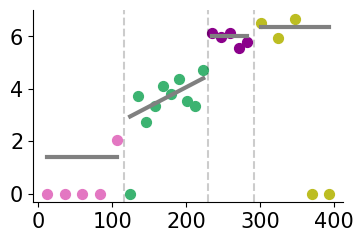

In [23]:
gene_name='Frmpd4'
print(f'gene {gene_name}: discontinuous after domain(s) {discont_genes_layer[gene_name]}') 
print(f'gene {gene_name}: continuous in domain(s) {cont_genes_layer[gene_name]}')

# display log CPM (if you want to do CP500, set offset=500)
offset=10**6

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(4,2.5), offset=offset, lw=3,
                                       domain_boundary_plotting=True)

gene Sbk1: large discontinuous jump after domain(s) []
gene Sbk1: large continuous gradient in domain(s) [1]


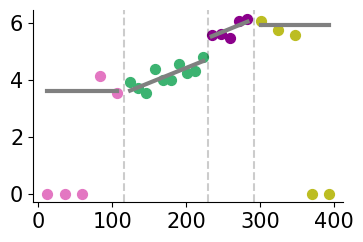

In [24]:
gene_name='Sbk1'
print(f'gene {gene_name}: large discontinuous jump after domain(s) {discont_genes_layer[gene_name]}') 
print(f'gene {gene_name}: large continuous gradient in domain(s) {cont_genes_layer[gene_name]}')

# display log CPM (if you want to do CP500, set offset=500)
offset=10**6

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(4,2.5), offset=offset, lw=3,
                                       domain_boundary_plotting=True)

 Cell type-attributable and other intradomain variation

In [25]:
domain_cts=plot_cell_types.get_domain_cts(binning_output, 0.5) # layer-specific cell types
cont_genes_layer_ct=spatial_gene_classification.get_cont_genes(pw_fit_dict, binning_output,
                                                               ct_attributable=True, 
                                                              domain_cts=domain_cts,
                                                               q=0.9,
                                                              ct_perc=0.4)

gene Calb1, continuous gradients [(1, 'Granule'), (2, 'Bergmann')]


Text(0.5, 1.0, 'Granule only')

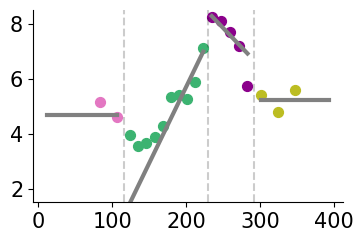

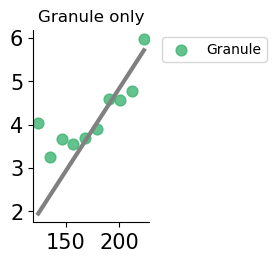

In [26]:
gene_name='Calb1'
print(f'gene {gene_name}, continuous gradients {cont_genes_layer_ct[gene_name]}')

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(4,2.5), offset=10**6, lw=3,
                                       domain_boundary_plotting=True)
plt.ylim((1.5,8.5))

# show cell type-specific functions in domain 1 (granule)
domain=1
cts=domain_cts[domain]

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, binning_output,
                                        cell_type_list=cts,ct_colors=ct_colors, spot_threshold=0.2, pt_size=60, 
                                        colors=domain_colors, linear_fit=True, domain_list=[domain],ticksize=15, 
                                        figsize=(1.5,2.5), offset=10**6, lw=3, alpha=0.8,show_lgd=True)
cts_list=' '.join(map(str, cts))
plt.title(f'{cts_list} only')

gene Camk1d, continuous gradients [(2, 'Bergmann'), (2, 'Purkinje'), (3, 'Other')]


Text(0.5, 1.0, 'MLI2 MLI1 only')

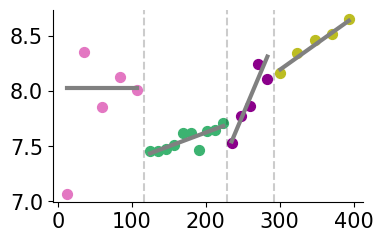

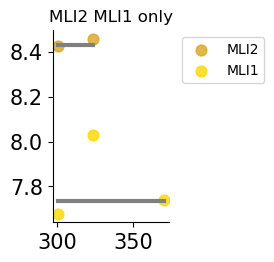

In [27]:
gene_name='Camk1d'
print(f'gene {gene_name}, continuous gradients {cont_genes_layer_ct[gene_name]}')

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(4,2.5), offset=10**6, lw=3,
                                       domain_boundary_plotting=True)

# show cell type-specific functions in domain 3 (MLI)
domain=3
cts=domain_cts[domain]

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, binning_output,
                                        cell_type_list=cts,ct_colors=ct_colors, spot_threshold=0.2, pt_size=60, 
                                        colors=domain_colors, linear_fit=True, domain_list=[domain],ticksize=15, 
                                        figsize=(1.5,2.5), offset=10**6, lw=3, alpha=0.8, show_lgd=True)
cts_list=' '.join(map(str, cts))
plt.title(f'{cts_list} only')